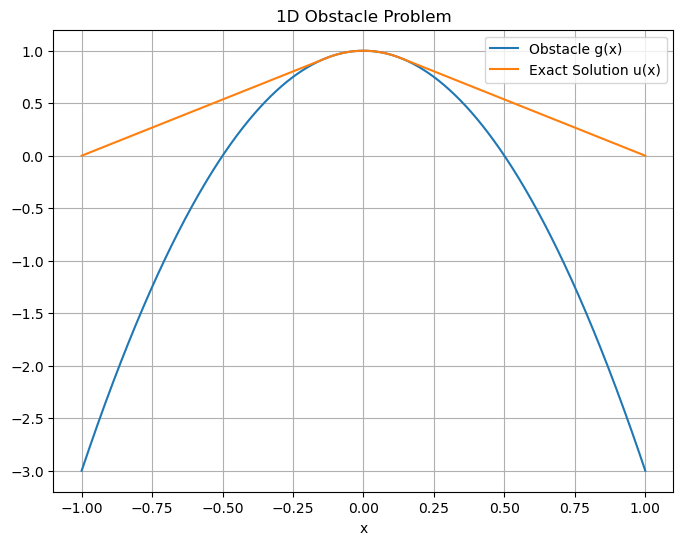

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    a=1-(3**0.5)/2
    out = np.zeros_like(x)
    for i in range(len(x)):
        if x[i]>=-a and x[i]<=a:
            out[i] = 1-4*(x[i]**2)
        elif (x[i]>=a and x[i]<=1): 
            out[i] = (1-4*(a**2))*(x[i]-1)/(a-1)
        elif (x[i]>=-1 and x[i]<=-a): 
            out[i] = (1-4*(a**2))*(x[i]+1)/(-a+1)
    return out


def g(x):
    return 1 - 4 * (x**2)   
y = np.linspace(-1,1,1000)
plt.figure(figsize=(8, 6))
plt.plot(y, g(y), label='Obstacle g(x)')
plt.plot(y, f(y), label='Exact Solution u(x)')
plt.xlabel('x')
plt.title('1D Obstacle Problem')
plt.legend()
plt.grid(True)
plt.show()

Epoch 0/10000, Loss: 287081.3125


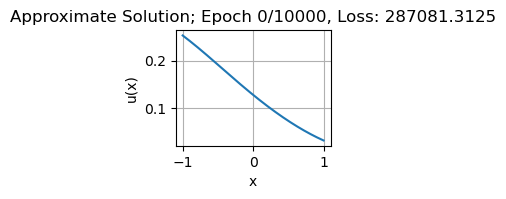

Epoch 1000/10000, Loss: 433.1793518066406


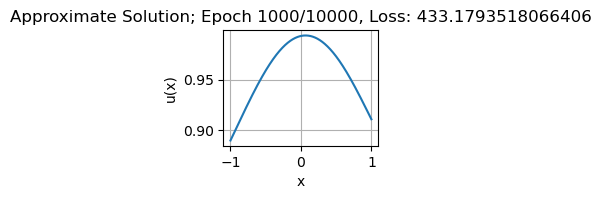

Epoch 2000/10000, Loss: 426.0599060058594


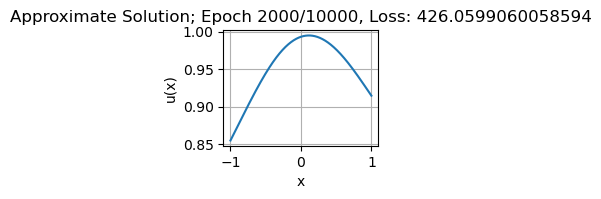

Epoch 3000/10000, Loss: 388.6732482910156


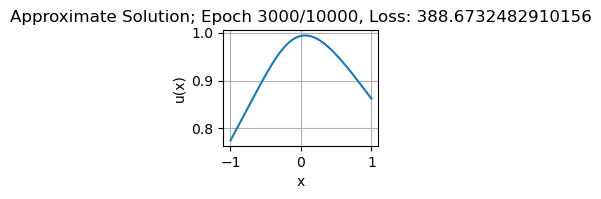

Epoch 4000/10000, Loss: 329.3193359375


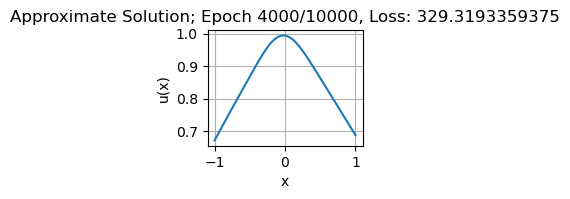

Epoch 5000/10000, Loss: 314.4928283691406


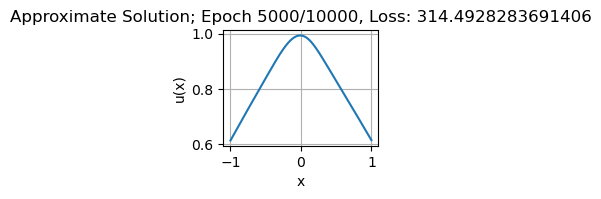

Epoch 6000/10000, Loss: 304.25396728515625


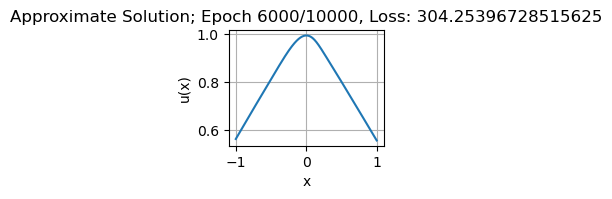

Epoch 7000/10000, Loss: 299.5230712890625


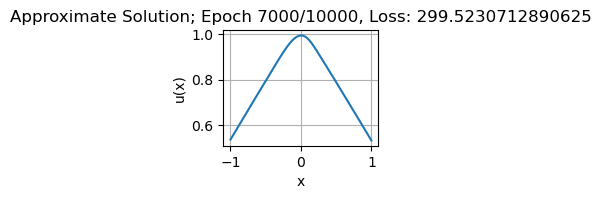

Epoch 8000/10000, Loss: 296.5553894042969


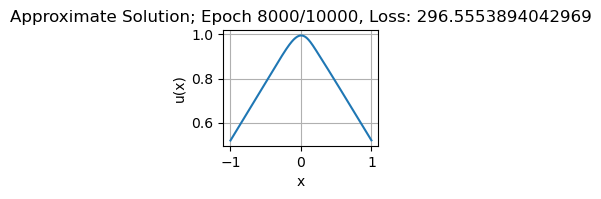

Epoch 9000/10000, Loss: 295.5373840332031


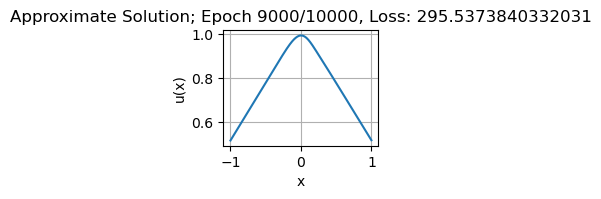

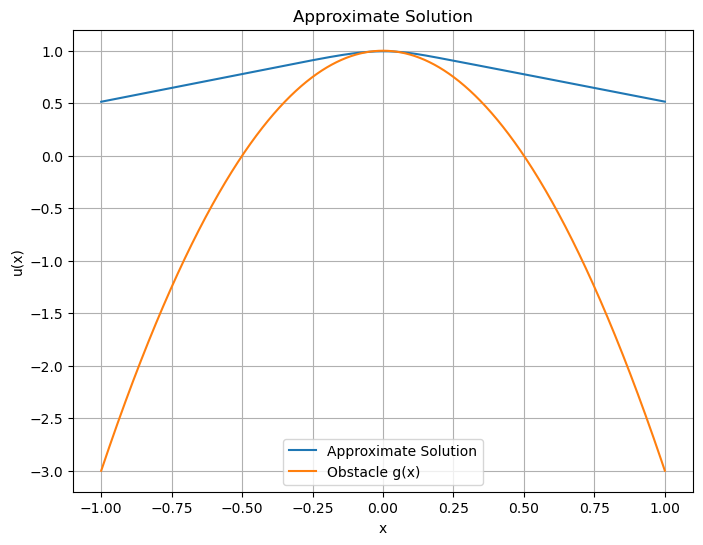

In [73]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from scipy.optimize import minimize

class DeepRitzNet(nn.Module):
    def __init__(self):
        super(DeepRitzNet, self).__init__()
        self.layer1 = nn.Linear(1, 20)
        self.layer2 = nn.Linear(20, 20)
        self.layer3 = nn.Linear(20, 20)
        self.layer4 = nn.Linear(20, 1)

    def forward(self, x):
        x = torch.tanh(self.layer1(x))
        x = torch.tanh(self.layer2(x))
        x = torch.tanh(self.layer3(x))
        x = self.layer4(x)
        return x

    
def energy_functional(u, x, g):
    u_prime = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_doubleprime = torch.autograd.grad(u_prime, x, grad_outputs=torch.ones_like(u_prime), create_graph=True, retain_graph=True)[0]

    energy = 0.5 * torch.sum(u_prime * u_prime) - torch.sum(g * u)
    
    # (u - g)(- u'') = 0
    obstacle_term = (u - g) * (- u_doubleprime)
    energy += (10**0) * torch.sum(torch.square(obstacle_term))

    penalty_1 = torch.sum((torch.square(torch.max(torch.zeros_like(u), g - u))))
    penalty_2 = torch.sum(torch.square(torch.max(torch.zeros_like(u), u_doubleprime)))
    energy += (10**(3)) * penalty_1 + (10**(3)) * penalty_2

    return torch.mean(energy)

def train(model, x, g, epochs=10000, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        u = model(x)
        
        energy = energy_functional(u, x, g)
        loss = energy  # We maximize the energy functional, equivalent to minimizing its negation
        loss.backward(retain_graph=True)
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
            x_np = x.detach().numpy()
            u_np = model(x)
            u_np = u_np.detach().numpy()

            plt.figure(figsize=(2, 1.5))
            plt.plot(x_np, u_np)
            plt.xlabel('x')
            plt.ylabel('u(x)')
            plt.title('Approximate Solution; '+f"Epoch {epoch}/{epochs}, Loss: {loss.item()}")
            plt.grid(True)
            plt.show()

def main():
    x = torch.linspace(-1, 1, 1400).reshape(-1, 1)
    x.requires_grad_(True)

    g = 1 - 4 * (x ** 2)  # obstacle function

    model = DeepRitzNet()

    train(model, x, g)

    u_approx = model(x)

    x_np = x.detach().numpy()
    u_approx_np = u_approx.detach().numpy()

    plt.figure(figsize=(8, 6))
    plt.plot(x_np, u_approx_np, label='Approximate Solution')
    plt.plot(x_np, g.detach().numpy(), label='Obstacle g(x)')
    plt.xlabel('x')
    plt.ylabel('u(x)')
    plt.title('Approximate Solution')
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
